In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier

In [2]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):

    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall, model_name="", color=None):

    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

In [3]:
train_path = 'data_feat_train.pkl'
test_path = 'data_feat_test.pkl'

In [4]:
train_df = pd.read_pickle(train_path)

In [5]:
#buy_time_vas
date = pd.to_datetime(train_df['buy_time_vas'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')

In [6]:
#time_delta
w_sc = StandardScaler().fit_transform(train_df['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

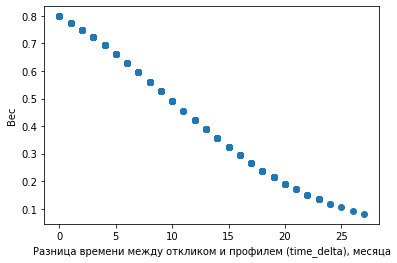

In [7]:
plt.scatter(train_df['time_delta'].values.reshape(-1,1)[:200]/(60*60*24*7),w[:200])
plt.xlabel('Разница времени между откликом и профилем (time_delta), месяца')
plt.ylabel('Вес')
plt.show()

In [8]:
train_df['time_delta'] = w

In [9]:
X = train_df.drop(['id','target','buy_time_vas'], axis=1)
y = train_df['target']

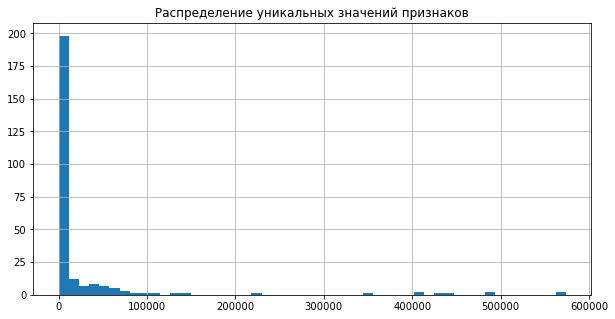

In [11]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=50, figsize=(10, 5));

In [12]:
f_all = set(X_nunique.index.tolist())
len(f_all)

255

In [13]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

In [14]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

248

In [15]:
f_other = f_all - (f_numeric | f_const )
len(f_other)

2

In [16]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_categorical

{'vas_id'}

In [17]:
f_other = f_other - f_categorical
f_other

{'252'}

In [18]:
X.loc[X['252']>1,:] = X['252'].value_counts().argmax()

In [19]:
f_categorical = f_categorical | {'252'}
f_other = f_other - {'252'}
len(f_other)

0

In [20]:
f_weight = {'time_delta'}
f_numeric = (f_numeric | f_other ) - f_weight

In [21]:
assert(X_nunique.shape[0] == len(f_const) + len(f_numeric) + len(f_categorical) + len(f_weight))

In [22]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_weght:', len(f_weight))


f_ok = list(f_categorical | f_numeric | f_weight)
f_categorical, f_numeric, f_weight = list(f_categorical), list(f_numeric), list(f_weight)

f_all: 255

f_const: 5
f_categorical: 2
f_numeric: 247
f_weght: 1


0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

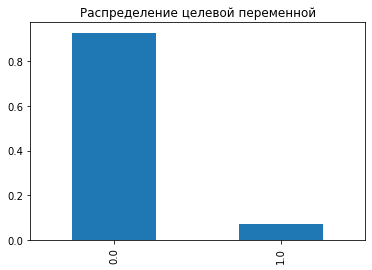

In [23]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

Логистическая регрессия

In [24]:
random_state = 22

X_train, X_valid, y_train, y_valid = train_test_split(X[f_ok], y, train_size=0.1, test_size=0.033, random_state=random_state)

columns_data = X_train.columns.drop(f_weight)

X_train_weight = X_train[f_weight].values.flatten()
X_valid_weight = X_valid[f_weight].values.flatten()

X_train = X_train.drop(f_weight, axis=1)
X_valid = X_valid.drop(f_weight, axis=1)

In [25]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

In [26]:
#Модель логистической регрессии с автоматической балансировкой классов
logreg_pp = Pipeline([
    ('prepoc', preproc_pipeline),
    ('selector', SelectPercentile()),
    ('model', LogisticRegression(n_jobs=-1,
                                 random_state=random_state,
                                 class_weight='balanced',
                                 max_iter=200))
])

In [27]:
params = {
    'selector__percentile': [5, 10],
    'model__C': [0.01, 0.1, 5]   
}

In [28]:
logreg_model = GridSearchCV(estimator=logreg_pp,
                            param_grid=params,
                            cv=3,
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=1,
                            refit=True)

In [29]:
%%time

_ = logreg_model.fit(X_train, y_train, model__sample_weight=X_train_weight)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   26.8s finished


Wall time: 31.6 s


In [30]:
pd.Series(logreg_model.best_params_)

model__C                5
selector__percentile    5
dtype: int64

In [31]:
logreg_proba_1 = logreg_model.predict_proba(X_valid)[:,1]
logreg_pred = logreg_model.predict(X_valid)

LogisticRegression: AUC_ROC = 0.851


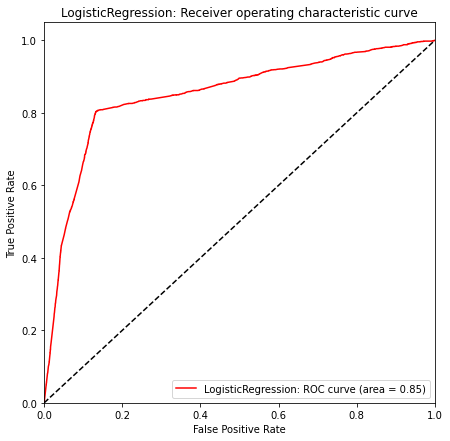

In [32]:
#ROC-кривая
fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

LogisticRegression: AUC_PR = 0.350


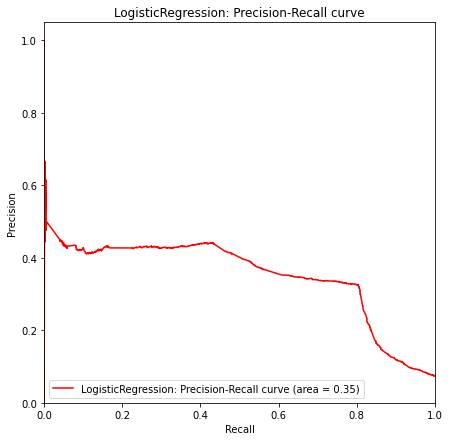

In [33]:
#Precision-Recall-кривая
precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1)

plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

In [34]:
#Матрица смежности
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[22054  3373]
 [  396  1622]]


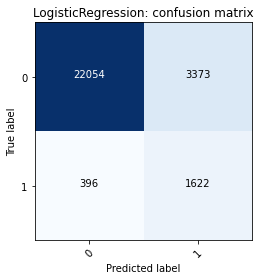

In [35]:
cm = confusion_matrix(y_valid, logreg_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="LogisticRegression");

В левом нижнем углу - ошибка первого рода, то есть клиент не получил предложения, хотя потенцаильно мог быть готов совершить подключение.

В правом верхнем углу - ошибка второго рода, от есть клиент получил предложение, хотя не собирался совершать подключение.

In [36]:
# выбирем порог 0.5
print(classification_report(y_valid, logreg_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25427
         1.0       0.32      0.80      0.46      2018

    accuracy                           0.86     27445
   macro avg       0.65      0.84      0.69     27445
weighted avg       0.93      0.86      0.89     27445



Catboost

In [37]:
selector = SelectPercentile()
X_cat = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat = pd.DataFrame(X_cat, columns=selected_columns)

X_cat[f_categorical] = X_cat[f_categorical].astype('int').astype('category')

In [38]:
random_state = 22

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_cat, y,
                                                                      train_size=0.1,
                                                                      test_size=0.033,
                                                                      random_state=random_state)

In [46]:
frozen_params = {
    'loss_function':'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 42,
    'logging_level': 'Verbose',
    #'task_type': 'GPU',
    'cat_features': f_categorical,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
}

In [47]:
%%time

cat_model = CatBoostClassifier(**frozen_params)

params_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 5, 10, 20],
    'bagging_temperature': [1, 1.5, 2]
}

Wall time: 0 ns


Рандомизированный поиск по сетке

In [48]:
%%time

search_result = cat_model.randomized_search(params_grid,
                                            X=X_train_cat,
                                            y=y_train_cat,
                                            cv=3,
                                            stratified=True,
                                            search_by_train_test_split=False,
                                            n_iter=30)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/3]
0:	learn: 0.8232219	test: 0.8087868	best: 0.8087868 (0)	total: 212ms	remaining: 21s
1:	learn: 0.8154010	test: 0.8026703	best: 0.8087868 (0)	total: 234ms	remaining: 11.5s
2:	learn: 0.8149885	test: 0.8021905	best: 0.8087868 (0)	total: 257ms	remaining: 8.3s
3:	learn: 0.8156840	test: 0.8026537	best: 0.8087868 (0)	total: 277ms	remaining: 6.66s
4:	learn: 0.8149885	test: 0.8021905	best: 0.8087868 (0)	total: 299ms	remaining: 5.68s
5:	learn: 0.8172456	test: 0.8038253	best: 0.8087868 (0)	total: 319ms	remaining: 4.99s
6:	learn: 0.8149885	test: 0.8021905	best: 0.8087868 (0)	total: 340ms	remaining: 4.52s
7:	learn: 0.8204595	test: 0.8063875	best: 0.8087868 (0)	total: 360ms	remaining: 4.14s
8:	learn: 0.8151427	test: 0.8021905	best: 0.8087868 (0)	total: 380ms	remaining: 3.84s
9:	learn: 0.8214553	test: 0.8079731	best: 0.8087868 (0)	total: 400ms	remaining: 3.6s
10:	learn: 0.8152802	test: 0.8024554	best: 0.8087868 (0)	total: 429ms	remaining: 3.47s
11:	learn: 0.8219301	test: 0.80878

15:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 462ms	remaining: 2.43s
16:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 484ms	remaining: 2.36s
17:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 506ms	remaining: 2.31s
18:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 536ms	remaining: 2.28s
19:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 560ms	remaining: 2.24s
20:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 581ms	remaining: 2.19s
21:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 603ms	remaining: 2.14s
22:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 630ms	remaining: 2.11s
23:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 657ms	remaining: 2.08s
24:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 686ms	remaining: 2.06s
25:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 707ms	remaining: 2.01s
26:	learn: 0.8100663	test: 0.8121152	best: 

61:	learn: 0.8159355	test: 0.8240650	best: 0.8240650 (61)	total: 1.37s	remaining: 842ms
62:	learn: 0.8159272	test: 0.8240650	best: 0.8240650 (61)	total: 1.4s	remaining: 820ms
63:	learn: 0.8158607	test: 0.8240318	best: 0.8240650 (61)	total: 1.42s	remaining: 797ms
64:	learn: 0.8158773	test: 0.8240318	best: 0.8240650 (61)	total: 1.45s	remaining: 781ms
65:	learn: 0.8158607	test: 0.8240318	best: 0.8240650 (61)	total: 1.47s	remaining: 758ms
66:	learn: 0.8158191	test: 0.8243169	best: 0.8243169 (66)	total: 1.49s	remaining: 735ms
67:	learn: 0.8158357	test: 0.8243502	best: 0.8243502 (67)	total: 1.51s	remaining: 712ms
68:	learn: 0.8158607	test: 0.8243668	best: 0.8243668 (68)	total: 1.53s	remaining: 689ms
69:	learn: 0.8158357	test: 0.8243502	best: 0.8243668 (68)	total: 1.55s	remaining: 666ms
70:	learn: 0.8158357	test: 0.8243668	best: 0.8243668 (68)	total: 1.58s	remaining: 647ms
71:	learn: 0.8158524	test: 0.8243668	best: 0.8243668 (68)	total: 1.6s	remaining: 624ms
72:	learn: 0.8158524	test: 0.82406

60:	learn: 0.8234301	test: 0.8090016	best: 0.8090347 (26)	total: 1.38s	remaining: 884ms
61:	learn: 0.8234301	test: 0.8090016	best: 0.8090347 (26)	total: 1.41s	remaining: 862ms
62:	learn: 0.8234301	test: 0.8090016	best: 0.8090347 (26)	total: 1.43s	remaining: 839ms
63:	learn: 0.8234301	test: 0.8090016	best: 0.8090347 (26)	total: 1.45s	remaining: 815ms
64:	learn: 0.8234468	test: 0.8090016	best: 0.8090347 (26)	total: 1.47s	remaining: 792ms
65:	learn: 0.8234551	test: 0.8090016	best: 0.8090347 (26)	total: 1.5s	remaining: 771ms
66:	learn: 0.8234635	test: 0.8090016	best: 0.8090347 (26)	total: 1.52s	remaining: 748ms
67:	learn: 0.8234635	test: 0.8090016	best: 0.8090347 (26)	total: 1.54s	remaining: 726ms
68:	learn: 0.8234635	test: 0.8090016	best: 0.8090347 (26)	total: 1.57s	remaining: 708ms
69:	learn: 0.8234718	test: 0.8090182	best: 0.8090347 (26)	total: 1.6s	remaining: 687ms
70:	learn: 0.8234718	test: 0.8090182	best: 0.8090347 (26)	total: 1.63s	remaining: 665ms
71:	learn: 0.8234718	test: 0.80901

27:	learn: 0.8157526	test: 0.8245520	best: 0.8246705 (4)	total: 815ms	remaining: 2.1s
28:	learn: 0.8157609	test: 0.8245520	best: 0.8246705 (4)	total: 839ms	remaining: 2.05s
29:	learn: 0.8157609	test: 0.8245354	best: 0.8246705 (4)	total: 866ms	remaining: 2.02s
30:	learn: 0.8157692	test: 0.8245686	best: 0.8246705 (4)	total: 888ms	remaining: 1.98s
31:	learn: 0.8157609	test: 0.8245520	best: 0.8246705 (4)	total: 916ms	remaining: 1.95s
32:	learn: 0.8157692	test: 0.8245520	best: 0.8246705 (4)	total: 961ms	remaining: 1.95s
33:	learn: 0.8157776	test: 0.8245686	best: 0.8246705 (4)	total: 995ms	remaining: 1.93s
34:	learn: 0.8157776	test: 0.8245686	best: 0.8246705 (4)	total: 1.02s	remaining: 1.89s
35:	learn: 0.8157776	test: 0.8245686	best: 0.8246705 (4)	total: 1.05s	remaining: 1.86s
36:	learn: 0.8157692	test: 0.8245520	best: 0.8246705 (4)	total: 1.07s	remaining: 1.82s
37:	learn: 0.8157692	test: 0.8245520	best: 0.8246705 (4)	total: 1.09s	remaining: 1.78s
38:	learn: 0.8157609	test: 0.8245520	best: 0

69:	learn: 0.8358657	test: 0.8067359	best: 0.8089686 (19)	total: 1.91s	remaining: 3.54s

bestTest = 0.8089685594
bestIteration = 19

Training on fold [1/3]
0:	learn: 0.8166551	test: 0.8220141	best: 0.8220141 (0)	total: 24.2ms	remaining: 4.82s
1:	learn: 0.8141017	test: 0.8139933	best: 0.8220141 (0)	total: 47.2ms	remaining: 4.68s
2:	learn: 0.8110272	test: 0.8129627	best: 0.8220141 (0)	total: 73.7ms	remaining: 4.84s
3:	learn: 0.8141682	test: 0.8143860	best: 0.8220141 (0)	total: 98.2ms	remaining: 4.81s
4:	learn: 0.8132809	test: 0.8139512	best: 0.8220141 (0)	total: 120ms	remaining: 4.69s
5:	learn: 0.8162793	test: 0.8186253	best: 0.8220141 (0)	total: 143ms	remaining: 4.61s
6:	learn: 0.8168886	test: 0.8212304	best: 0.8220141 (0)	total: 166ms	remaining: 4.57s
7:	learn: 0.8169467	test: 0.8212638	best: 0.8220141 (0)	total: 187ms	remaining: 4.49s
8:	learn: 0.8170131	test: 0.8207374	best: 0.8220141 (0)	total: 208ms	remaining: 4.42s
9:	learn: 0.8170297	test: 0.8210926	best: 0.8220141 (0)	total: 232

43:	learn: 0.8187735	test: 0.8221512	best: 0.8242171 (14)	total: 1.03s	remaining: 3.66s
44:	learn: 0.8187985	test: 0.8221678	best: 0.8242171 (14)	total: 1.06s	remaining: 3.66s
45:	learn: 0.8194423	test: 0.8221346	best: 0.8242171 (14)	total: 1.08s	remaining: 3.63s
46:	learn: 0.8194256	test: 0.8221013	best: 0.8242171 (14)	total: 1.1s	remaining: 3.59s
47:	learn: 0.8200605	test: 0.8220514	best: 0.8242171 (14)	total: 1.13s	remaining: 3.56s
48:	learn: 0.8208135	test: 0.8220681	best: 0.8242171 (14)	total: 1.15s	remaining: 3.53s
49:	learn: 0.8206280	test: 0.8218317	best: 0.8242171 (14)	total: 1.17s	remaining: 3.51s
50:	learn: 0.8211428	test: 0.8218483	best: 0.8242171 (14)	total: 1.19s	remaining: 3.47s
51:	learn: 0.8214553	test: 0.8215619	best: 0.8242171 (14)	total: 1.22s	remaining: 3.47s
52:	learn: 0.8220214	test: 0.8206186	best: 0.8242171 (14)	total: 1.25s	remaining: 3.46s
53:	learn: 0.8214053	test: 0.8212421	best: 0.8242171 (14)	total: 1.27s	remaining: 3.43s
54:	learn: 0.8216843	test: 0.8209

0:	learn: 0.8166551	test: 0.8220141	best: 0.8220141 (0)	total: 24.3ms	remaining: 12.1s
1:	learn: 0.8137312	test: 0.8131484	best: 0.8220141 (0)	total: 49.9ms	remaining: 12.4s
2:	learn: 0.8103351	test: 0.8120985	best: 0.8220141 (0)	total: 72.6ms	remaining: 12s
3:	learn: 0.8139684	test: 0.8132152	best: 0.8220141 (0)	total: 97.4ms	remaining: 12.1s
4:	learn: 0.8105705	test: 0.8120818	best: 0.8220141 (0)	total: 122ms	remaining: 12.1s
5:	learn: 0.8101966	test: 0.8120985	best: 0.8220141 (0)	total: 147ms	remaining: 12.1s
6:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 169ms	remaining: 11.9s
7:	learn: 0.8105373	test: 0.8123923	best: 0.8220141 (0)	total: 190ms	remaining: 11.7s
8:	learn: 0.8140475	test: 0.8147785	best: 0.8220141 (0)	total: 212ms	remaining: 11.6s
9:	learn: 0.8137517	test: 0.8139178	best: 0.8220141 (0)	total: 236ms	remaining: 11.6s
10:	learn: 0.8126672	test: 0.8128291	best: 0.8220141 (0)	total: 258ms	remaining: 11.5s
11:	learn: 0.8143138	test: 0.8146950	best: 0.822014

25:	learn: 0.8157776	test: 0.8245520	best: 0.8246186 (18)	total: 639ms	remaining: 11.7s
26:	learn: 0.8157859	test: 0.8245853	best: 0.8246186 (18)	total: 664ms	remaining: 11.6s
27:	learn: 0.8158025	test: 0.8245853	best: 0.8246186 (18)	total: 688ms	remaining: 11.6s
28:	learn: 0.8157942	test: 0.8245853	best: 0.8246186 (18)	total: 710ms	remaining: 11.5s
29:	learn: 0.8160270	test: 0.8230226	best: 0.8246186 (18)	total: 739ms	remaining: 11.6s
30:	learn: 0.8160270	test: 0.8230060	best: 0.8246186 (18)	total: 762ms	remaining: 11.5s
31:	learn: 0.8160602	test: 0.8230226	best: 0.8246186 (18)	total: 784ms	remaining: 11.5s
32:	learn: 0.8160436	test: 0.8224173	best: 0.8246186 (18)	total: 807ms	remaining: 11.4s
33:	learn: 0.8160519	test: 0.8224173	best: 0.8246186 (18)	total: 836ms	remaining: 11.5s
34:	learn: 0.8160686	test: 0.8224173	best: 0.8246186 (18)	total: 863ms	remaining: 11.5s
35:	learn: 0.8160602	test: 0.8224006	best: 0.8246186 (18)	total: 888ms	remaining: 11.4s
36:	learn: 0.8160686	test: 0.822

0:	learn: 0.8169769	test: 0.8204248	best: 0.8204248 (0)	total: 52.4ms	remaining: 5.19s
1:	learn: 0.8147088	test: 0.8151288	best: 0.8204248 (0)	total: 93.8ms	remaining: 4.6s
2:	learn: 0.8167559	test: 0.8210467	best: 0.8210467 (2)	total: 130ms	remaining: 4.21s
3:	learn: 0.8167897	test: 0.8178722	best: 0.8210467 (2)	total: 168ms	remaining: 4.03s
4:	learn: 0.8151367	test: 0.8160537	best: 0.8210467 (2)	total: 213ms	remaining: 4.04s
5:	learn: 0.8164668	test: 0.8179223	best: 0.8210467 (2)	total: 251ms	remaining: 3.94s
6:	learn: 0.8158749	test: 0.8176654	best: 0.8210467 (2)	total: 288ms	remaining: 3.83s
7:	learn: 0.8179250	test: 0.8180288	best: 0.8210467 (2)	total: 324ms	remaining: 3.73s
8:	learn: 0.8181193	test: 0.8183187	best: 0.8210467 (2)	total: 361ms	remaining: 3.65s
9:	learn: 0.8182107	test: 0.8173649	best: 0.8210467 (2)	total: 398ms	remaining: 3.58s
10:	learn: 0.8181110	test: 0.8183521	best: 0.8210467 (2)	total: 434ms	remaining: 3.51s
11:	learn: 0.8180943	test: 0.8183187	best: 0.8210467

41:	learn: 0.8337668	test: 0.8173562	best: 0.8244334 (7)	total: 1.5s	remaining: 2.07s
42:	learn: 0.8353626	test: 0.8179340	best: 0.8244334 (7)	total: 1.54s	remaining: 2.05s
43:	learn: 0.8355555	test: 0.8184056	best: 0.8244334 (7)	total: 1.58s	remaining: 2.01s
44:	learn: 0.8363152	test: 0.8187440	best: 0.8244334 (7)	total: 1.61s	remaining: 1.97s
45:	learn: 0.8371160	test: 0.8187274	best: 0.8244334 (7)	total: 1.65s	remaining: 1.94s
46:	learn: 0.8386392	test: 0.8184056	best: 0.8244334 (7)	total: 1.7s	remaining: 1.92s
47:	learn: 0.8394588	test: 0.8180836	best: 0.8244334 (7)	total: 1.74s	remaining: 1.89s
48:	learn: 0.8419811	test: 0.8183557	best: 0.8244334 (7)	total: 1.77s	remaining: 1.85s
49:	learn: 0.8436386	test: 0.8179673	best: 0.8244334 (7)	total: 1.81s	remaining: 1.81s
50:	learn: 0.8442081	test: 0.8177117	best: 0.8244334 (7)	total: 1.85s	remaining: 1.77s
51:	learn: 0.8440448	test: 0.8180171	best: 0.8244334 (7)	total: 1.89s	remaining: 1.74s
52:	learn: 0.8448612	test: 0.8176950	best: 0.

14:	learn: 0.8192761	test: 0.8168506	best: 0.8204703 (2)	total: 636ms	remaining: 7.84s
15:	learn: 0.8194285	test: 0.8164763	best: 0.8204703 (2)	total: 679ms	remaining: 7.81s
16:	learn: 0.8212300	test: 0.8170243	best: 0.8204703 (2)	total: 727ms	remaining: 7.82s
17:	learn: 0.8213050	test: 0.8167671	best: 0.8204703 (2)	total: 767ms	remaining: 7.76s
18:	learn: 0.8217690	test: 0.8170410	best: 0.8204703 (2)	total: 808ms	remaining: 7.7s
19:	learn: 0.8221227	test: 0.8164429	best: 0.8204703 (2)	total: 844ms	remaining: 7.6s
20:	learn: 0.8222911	test: 0.8164596	best: 0.8204703 (2)	total: 887ms	remaining: 7.56s
21:	learn: 0.8221393	test: 0.8162021	best: 0.8204703 (2)	total: 925ms	remaining: 7.49s
22:	learn: 0.8231925	test: 0.8155863	best: 0.8204703 (2)	total: 964ms	remaining: 7.42s
23:	learn: 0.8239662	test: 0.8161854	best: 0.8204703 (2)	total: 1s	remaining: 7.35s
24:	learn: 0.8251162	test: 0.8159443	best: 0.8204703 (2)	total: 1.04s	remaining: 7.26s
25:	learn: 0.8255692	test: 0.8156531	best: 0.820

0:	learn: 0.8244127	test: 0.8077627	best: 0.8077627 (0)	total: 118ms	remaining: 11.7s
1:	learn: 0.8240532	test: 0.8069541	best: 0.8077627 (0)	total: 235ms	remaining: 11.5s
2:	learn: 0.8235872	test: 0.8072579	best: 0.8077627 (0)	total: 403ms	remaining: 13s
3:	learn: 0.8234774	test: 0.8086470	best: 0.8086470 (3)	total: 442ms	remaining: 10.6s
4:	learn: 0.8234454	test: 0.8087417	best: 0.8087417 (4)	total: 650ms	remaining: 12.3s
5:	learn: 0.8236789	test: 0.8086966	best: 0.8087417 (4)	total: 846ms	remaining: 13.3s
6:	learn: 0.8239292	test: 0.8080147	best: 0.8087417 (4)	total: 978ms	remaining: 13s
7:	learn: 0.8249708	test: 0.8076088	best: 0.8087417 (4)	total: 1.1s	remaining: 12.7s
8:	learn: 0.8250543	test: 0.8072154	best: 0.8087417 (4)	total: 1.25s	remaining: 12.7s
9:	learn: 0.8256165	test: 0.8069872	best: 0.8087417 (4)	total: 1.42s	remaining: 12.8s
10:	learn: 0.8266061	test: 0.8056950	best: 0.8087417 (4)	total: 1.57s	remaining: 12.7s
11:	learn: 0.8285812	test: 0.8050545	best: 0.8087417 (4)	t

40:	learn: 0.8802430	test: 0.8033910	best: 0.8216354 (1)	total: 6.2s	remaining: 8.92s
41:	learn: 0.8830634	test: 0.8032909	best: 0.8216354 (1)	total: 6.38s	remaining: 8.81s
42:	learn: 0.8838909	test: 0.8028757	best: 0.8216354 (1)	total: 6.56s	remaining: 8.7s
43:	learn: 0.8873297	test: 0.8019932	best: 0.8216354 (1)	total: 6.69s	remaining: 8.52s
44:	learn: 0.8894124	test: 0.8000735	best: 0.8216354 (1)	total: 6.83s	remaining: 8.35s
45:	learn: 0.8921707	test: 0.8002734	best: 0.8216354 (1)	total: 6.95s	remaining: 8.16s
46:	learn: 0.8937874	test: 0.8002901	best: 0.8216354 (1)	total: 7.06s	remaining: 7.96s
47:	learn: 0.8972998	test: 0.7987328	best: 0.8216354 (1)	total: 7.17s	remaining: 7.77s
48:	learn: 0.9030742	test: 0.7968018	best: 0.8216354 (1)	total: 7.29s	remaining: 7.59s
49:	learn: 0.9045245	test: 0.7938470	best: 0.8216354 (1)	total: 7.45s	remaining: 7.45s
50:	learn: 0.9057675	test: 0.7936366	best: 0.8216354 (1)	total: 7.58s	remaining: 7.28s
51:	learn: 0.9081856	test: 0.7916965	best: 0.

28:	learn: 0.8245274	test: 0.8083537	best: 0.8090347 (16)	total: 3.09s	remaining: 50.2s
29:	learn: 0.8244690	test: 0.8083702	best: 0.8090347 (16)	total: 3.23s	remaining: 50.6s
30:	learn: 0.8245107	test: 0.8083868	best: 0.8090347 (16)	total: 3.35s	remaining: 50.7s
31:	learn: 0.8247621	test: 0.8080767	best: 0.8090347 (16)	total: 3.5s	remaining: 51.2s
32:	learn: 0.8247621	test: 0.8080767	best: 0.8090347 (16)	total: 3.53s	remaining: 50s
33:	learn: 0.8252323	test: 0.8080933	best: 0.8090347 (16)	total: 3.67s	remaining: 50.3s
34:	learn: 0.8254084	test: 0.8080933	best: 0.8090347 (16)	total: 3.78s	remaining: 50.2s
35:	learn: 0.8255594	test: 0.8080933	best: 0.8090347 (16)	total: 3.97s	remaining: 51.2s
36:	learn: 0.8256012	test: 0.8081264	best: 0.8090347 (16)	total: 4.09s	remaining: 51.1s
37:	learn: 0.8256095	test: 0.8081429	best: 0.8090347 (16)	total: 4.19s	remaining: 51s
38:	learn: 0.8257856	test: 0.8081264	best: 0.8090347 (16)	total: 4.33s	remaining: 51.2s
39:	learn: 0.8261543	test: 0.8088621	

2:	learn: 0.8163883	test: 0.8230559	best: 0.8241150 (1)	total: 308ms	remaining: 51s
3:	learn: 0.8162719	test: 0.8238962	best: 0.8241150 (1)	total: 422ms	remaining: 52.4s
4:	learn: 0.8163145	test: 0.8220442	best: 0.8241150 (1)	total: 526ms	remaining: 52.1s
5:	learn: 0.8157927	test: 0.8215334	best: 0.8241150 (1)	total: 627ms	remaining: 51.6s
6:	learn: 0.8168546	test: 0.8221108	best: 0.8241150 (1)	total: 728ms	remaining: 51.3s
7:	learn: 0.8165049	test: 0.8233417	best: 0.8241150 (1)	total: 831ms	remaining: 51.1s
8:	learn: 0.8162968	test: 0.8228563	best: 0.8241150 (1)	total: 928ms	remaining: 50.6s
9:	learn: 0.8160103	test: 0.8231753	best: 0.8241150 (1)	total: 1.03s	remaining: 50.6s
10:	learn: 0.8161018	test: 0.8229894	best: 0.8241150 (1)	total: 1.14s	remaining: 50.5s
11:	learn: 0.8162183	test: 0.8230393	best: 0.8241150 (1)	total: 1.25s	remaining: 50.7s
12:	learn: 0.8163431	test: 0.8231558	best: 0.8241150 (1)	total: 1.36s	remaining: 51.1s
13:	learn: 0.8162183	test: 0.8230726	best: 0.8241150 

43:	learn: 0.8233801	test: 0.8089355	best: 0.8096634 (25)	total: 4.18s	remaining: 43.3s
44:	learn: 0.8233718	test: 0.8089024	best: 0.8096634 (25)	total: 4.28s	remaining: 43.3s
45:	learn: 0.8234468	test: 0.8089355	best: 0.8096634 (25)	total: 4.38s	remaining: 43.3s
46:	learn: 0.8233968	test: 0.8089024	best: 0.8096634 (25)	total: 4.48s	remaining: 43.2s
47:	learn: 0.8234468	test: 0.8089686	best: 0.8096634 (25)	total: 4.59s	remaining: 43.2s
48:	learn: 0.8234801	test: 0.8089686	best: 0.8096634 (25)	total: 4.7s	remaining: 43.3s
49:	learn: 0.8235218	test: 0.8089851	best: 0.8096634 (25)	total: 4.81s	remaining: 43.3s
50:	learn: 0.8234801	test: 0.8089686	best: 0.8096634 (25)	total: 4.9s	remaining: 43.2s
51:	learn: 0.8234801	test: 0.8089686	best: 0.8096634 (25)	total: 5.01s	remaining: 43.2s
52:	learn: 0.8234551	test: 0.8089355	best: 0.8096634 (25)	total: 5.12s	remaining: 43.2s
53:	learn: 0.8234801	test: 0.8089851	best: 0.8096634 (25)	total: 5.22s	remaining: 43.1s
54:	learn: 0.8234635	test: 0.80898

9:	learn: 0.8156612	test: 0.8237823	best: 0.8245208 (1)	total: 1.02s	remaining: 50.2s
10:	learn: 0.8155117	test: 0.8242526	best: 0.8245208 (1)	total: 1.13s	remaining: 50.3s
11:	learn: 0.8156861	test: 0.8232115	best: 0.8245208 (1)	total: 1.24s	remaining: 50.4s
12:	learn: 0.8158690	test: 0.8234610	best: 0.8245208 (1)	total: 1.34s	remaining: 50.4s
13:	learn: 0.8157609	test: 0.8232447	best: 0.8245208 (1)	total: 1.44s	remaining: 50.1s
14:	learn: 0.8156114	test: 0.8237823	best: 0.8245208 (1)	total: 1.48s	remaining: 47.7s
15:	learn: 0.8157443	test: 0.8235967	best: 0.8245208 (1)	total: 1.58s	remaining: 47.7s
16:	learn: 0.8156197	test: 0.8240840	best: 0.8245208 (1)	total: 1.61s	remaining: 45.7s
17:	learn: 0.8157111	test: 0.8235801	best: 0.8245208 (1)	total: 1.71s	remaining: 45.8s
18:	learn: 0.8159189	test: 0.8231753	best: 0.8245208 (1)	total: 1.81s	remaining: 45.9s
19:	learn: 0.8158199	test: 0.8228199	best: 0.8245208 (1)	total: 1.91s	remaining: 45.9s
20:	learn: 0.8158872	test: 0.8215707	best: 0

0:	learn: 0.8166551	test: 0.8220141	best: 0.8220141 (0)	total: 24ms	remaining: 2.38s
1:	learn: 0.8145759	test: 0.8165026	best: 0.8220141 (0)	total: 45.6ms	remaining: 2.23s
2:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 62.2ms	remaining: 2.01s
3:	learn: 0.8100663	test: 0.8121152	best: 0.8220141 (0)	total: 78.3ms	remaining: 1.88s
4:	learn: 0.8164858	test: 0.8201053	best: 0.8220141 (0)	total: 92.7ms	remaining: 1.76s
5:	learn: 0.8145094	test: 0.8169439	best: 0.8220141 (0)	total: 108ms	remaining: 1.69s
6:	learn: 0.8171210	test: 0.8201770	best: 0.8220141 (0)	total: 124ms	remaining: 1.65s
7:	learn: 0.8172539	test: 0.8203774	best: 0.8220141 (0)	total: 138ms	remaining: 1.59s
8:	learn: 0.8170229	test: 0.8197996	best: 0.8220141 (0)	total: 153ms	remaining: 1.54s
9:	learn: 0.8168700	test: 0.8197996	best: 0.8220141 (0)	total: 168ms	remaining: 1.51s
10:	learn: 0.8167586	test: 0.8198330	best: 0.8220141 (0)	total: 179ms	remaining: 1.45s
11:	learn: 0.8172356	test: 0.8207207	best: 0.82201

47:	learn: 0.8170915	test: 0.8231088	best: 0.8245354 (3)	total: 808ms	remaining: 876ms
48:	learn: 0.8172696	test: 0.8231254	best: 0.8245354 (3)	total: 829ms	remaining: 863ms
49:	learn: 0.8171082	test: 0.8230922	best: 0.8245354 (3)	total: 846ms	remaining: 846ms
50:	learn: 0.8172530	test: 0.8230922	best: 0.8245354 (3)	total: 862ms	remaining: 829ms
51:	learn: 0.8174060	test: 0.8230755	best: 0.8245354 (3)	total: 879ms	remaining: 811ms
52:	learn: 0.8175891	test: 0.8225869	best: 0.8245354 (3)	total: 894ms	remaining: 793ms
53:	learn: 0.8177838	test: 0.8226202	best: 0.8245354 (3)	total: 913ms	remaining: 777ms

bestTest = 0.8245353711
bestIteration = 3

9:	loss: 0.8171614	best: 0.8182764 (1)	total: 1m 41s	remaining: 3m 22s
Training on fold [0/3]
0:	learn: 0.8232219	test: 0.8087868	best: 0.8087868 (0)	total: 14.7ms	remaining: 1.46s
1:	learn: 0.8192933	test: 0.8069940	best: 0.8087868 (0)	total: 29.9ms	remaining: 1.46s
2:	learn: 0.8232219	test: 0.8087868	best: 0.8087868 (0)	total: 43.7ms	remaining

11:	learn: 0.8132817	test: 0.8146783	best: 0.8220141 (0)	total: 217ms	remaining: 1.59s
12:	learn: 0.8166790	test: 0.8201269	best: 0.8220141 (0)	total: 236ms	remaining: 1.58s
13:	learn: 0.8169467	test: 0.8214850	best: 0.8220141 (0)	total: 254ms	remaining: 1.56s
14:	learn: 0.8167476	test: 0.8216894	best: 0.8220141 (0)	total: 272ms	remaining: 1.54s
15:	learn: 0.8168222	test: 0.8217228	best: 0.8220141 (0)	total: 290ms	remaining: 1.52s
16:	learn: 0.8166812	test: 0.8216393	best: 0.8220141 (0)	total: 306ms	remaining: 1.49s
17:	learn: 0.8167891	test: 0.8216894	best: 0.8220141 (0)	total: 327ms	remaining: 1.49s
18:	learn: 0.8168222	test: 0.8217061	best: 0.8220141 (0)	total: 346ms	remaining: 1.48s
19:	learn: 0.8166315	test: 0.8216226	best: 0.8220141 (0)	total: 362ms	remaining: 1.45s
20:	learn: 0.8166729	test: 0.8216393	best: 0.8220141 (0)	total: 379ms	remaining: 1.43s
21:	learn: 0.8167144	test: 0.8216894	best: 0.8220141 (0)	total: 401ms	remaining: 1.42s
22:	learn: 0.8167393	test: 0.8216894	best: 

58:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.12s	remaining: 781ms
59:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.14s	remaining: 763ms
60:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.16s	remaining: 744ms
61:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.18s	remaining: 724ms
62:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.2s	remaining: 705ms
63:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.22s	remaining: 684ms
64:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.23s	remaining: 665ms
65:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.25s	remaining: 645ms
66:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.27s	remaining: 626ms
67:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.29s	remaining: 606ms
68:	learn: 0.8157609	test: 0.8245354	best: 0.8246040 (18)	total: 1.31s	remaining: 591ms

bestTest = 0.8246039551
bestIter

34:	learn: 0.8168729	test: 0.8168102	best: 0.8204248 (0)	total: 1.35s	remaining: 6.37s
35:	learn: 0.8162934	test: 0.8165360	best: 0.8204248 (0)	total: 1.39s	remaining: 6.33s
36:	learn: 0.8162315	test: 0.8165694	best: 0.8204248 (0)	total: 1.42s	remaining: 6.28s
37:	learn: 0.8167198	test: 0.8168603	best: 0.8204248 (0)	total: 1.46s	remaining: 6.22s
38:	learn: 0.8163100	test: 0.8165861	best: 0.8204248 (0)	total: 1.5s	remaining: 6.2s
39:	learn: 0.8169678	test: 0.8171010	best: 0.8204248 (0)	total: 1.55s	remaining: 6.18s
40:	learn: 0.8164300	test: 0.8171511	best: 0.8204248 (0)	total: 1.58s	remaining: 6.13s
41:	learn: 0.8160034	test: 0.8171679	best: 0.8204248 (0)	total: 1.62s	remaining: 6.09s
42:	learn: 0.8168729	test: 0.8170676	best: 0.8204248 (0)	total: 1.66s	remaining: 6.04s
43:	learn: 0.8164383	test: 0.8171846	best: 0.8204248 (0)	total: 1.68s	remaining: 5.96s
44:	learn: 0.8163100	test: 0.8171846	best: 0.8204248 (0)	total: 1.73s	remaining: 5.94s
45:	learn: 0.8158915	test: 0.8169105	best: 0.

79:	learn: 0.8159355	test: 0.8240983	best: 0.8244168 (78)	total: 3.08s	remaining: 4.62s
80:	learn: 0.8159189	test: 0.8244001	best: 0.8244168 (78)	total: 3.12s	remaining: 4.58s
81:	learn: 0.8159272	test: 0.8244168	best: 0.8244168 (78)	total: 3.15s	remaining: 4.54s
82:	learn: 0.8159355	test: 0.8240983	best: 0.8244168 (78)	total: 3.19s	remaining: 4.5s
83:	learn: 0.8159438	test: 0.8240983	best: 0.8244168 (78)	total: 3.23s	remaining: 4.46s
84:	learn: 0.8159521	test: 0.8241150	best: 0.8244168 (78)	total: 3.27s	remaining: 4.42s
85:	learn: 0.8159272	test: 0.8244334	best: 0.8244334 (85)	total: 3.31s	remaining: 4.39s
86:	learn: 0.8159355	test: 0.8241316	best: 0.8244334 (85)	total: 3.35s	remaining: 4.36s
87:	learn: 0.8159272	test: 0.8241316	best: 0.8244334 (85)	total: 3.39s	remaining: 4.32s
88:	learn: 0.8159189	test: 0.8241316	best: 0.8244334 (85)	total: 3.43s	remaining: 4.28s
89:	learn: 0.8159272	test: 0.8241316	best: 0.8244334 (85)	total: 3.46s	remaining: 4.24s
90:	learn: 0.8159272	test: 0.8241

36:	learn: 0.8881054	test: 0.7681772	best: 0.8080353 (6)	total: 3.81s	remaining: 6.49s
37:	learn: 0.8901089	test: 0.7669185	best: 0.8080353 (6)	total: 3.91s	remaining: 6.39s
38:	learn: 0.8921656	test: 0.7677602	best: 0.8080353 (6)	total: 4.02s	remaining: 6.29s
39:	learn: 0.8950185	test: 0.7662141	best: 0.8080353 (6)	total: 4.13s	remaining: 6.2s
40:	learn: 0.8970949	test: 0.7669349	best: 0.8080353 (6)	total: 4.23s	remaining: 6.09s
41:	learn: 0.8996921	test: 0.7662392	best: 0.8080353 (6)	total: 4.34s	remaining: 5.99s
42:	learn: 0.9026537	test: 0.7637407	best: 0.8080353 (6)	total: 4.45s	remaining: 5.9s
43:	learn: 0.9067730	test: 0.7620664	best: 0.8080353 (6)	total: 4.56s	remaining: 5.8s
44:	learn: 0.9090460	test: 0.7631306	best: 0.8080353 (6)	total: 4.66s	remaining: 5.7s
45:	learn: 0.9107364	test: 0.7577003	best: 0.8080353 (6)	total: 4.77s	remaining: 5.61s
46:	learn: 0.9130196	test: 0.7573612	best: 0.8080353 (6)	total: 4.88s	remaining: 5.5s
47:	learn: 0.9165934	test: 0.7544088	best: 0.808

23:	learn: 0.8557775	test: 0.7983961	best: 0.8223806 (3)	total: 2.5s	remaining: 7.93s
24:	learn: 0.8603613	test: 0.7958396	best: 0.8223806 (3)	total: 2.61s	remaining: 7.82s
25:	learn: 0.8623607	test: 0.7925774	best: 0.8223806 (3)	total: 2.71s	remaining: 7.71s
26:	learn: 0.8652897	test: 0.7916660	best: 0.8223806 (3)	total: 2.82s	remaining: 7.63s
27:	learn: 0.8686891	test: 0.7908026	best: 0.8223806 (3)	total: 2.93s	remaining: 7.54s
28:	learn: 0.8702740	test: 0.7894508	best: 0.8223806 (3)	total: 3.04s	remaining: 7.44s
29:	learn: 0.8718554	test: 0.7892527	best: 0.8223806 (3)	total: 3.14s	remaining: 7.32s
30:	learn: 0.8748966	test: 0.7870427	best: 0.8223806 (3)	total: 3.25s	remaining: 7.23s
31:	learn: 0.8757134	test: 0.7864781	best: 0.8223806 (3)	total: 3.35s	remaining: 7.13s
32:	learn: 0.8784144	test: 0.7854566	best: 0.8223806 (3)	total: 3.46s	remaining: 7.03s
33:	learn: 0.8796896	test: 0.7827949	best: 0.8223806 (3)	total: 3.57s	remaining: 6.92s
34:	learn: 0.8823003	test: 0.7836937	best: 0

9:	learn: 0.8193759	test: 0.8194383	best: 0.8223982 (1)	total: 1.05s	remaining: 19.9s
10:	learn: 0.8199165	test: 0.8191154	best: 0.8223982 (1)	total: 1.16s	remaining: 19.9s
11:	learn: 0.8215652	test: 0.8193715	best: 0.8223982 (1)	total: 1.26s	remaining: 19.8s
12:	learn: 0.8236455	test: 0.8187422	best: 0.8223982 (1)	total: 1.36s	remaining: 19.6s
13:	learn: 0.8259461	test: 0.8188592	best: 0.8223982 (1)	total: 1.47s	remaining: 19.5s
14:	learn: 0.8272854	test: 0.8159276	best: 0.8223982 (1)	total: 1.58s	remaining: 19.5s
15:	learn: 0.8293893	test: 0.8158943	best: 0.8223982 (1)	total: 1.69s	remaining: 19.4s
16:	learn: 0.8302477	test: 0.8147616	best: 0.8223982 (1)	total: 1.8s	remaining: 19.4s
17:	learn: 0.8313457	test: 0.8150200	best: 0.8223982 (1)	total: 1.9s	remaining: 19.2s
18:	learn: 0.8315706	test: 0.8144530	best: 0.8223982 (1)	total: 1.99s	remaining: 18.9s
19:	learn: 0.8335615	test: 0.8147449	best: 0.8223982 (1)	total: 2.1s	remaining: 18.9s
20:	learn: 0.8342663	test: 0.8135262	best: 0.82

52:	learn: 0.8948124	test: 0.7992415	best: 0.8244189 (2)	total: 5.67s	remaining: 15.7s

bestTest = 0.8244189183
bestIteration = 2

13:	loss: 0.7970081	best: 0.8184089 (10)	total: 2m 30s	remaining: 2m 51s
Training on fold [0/3]
0:	learn: 0.8244127	test: 0.8077627	best: 0.8077627 (0)	total: 106ms	remaining: 21s
1:	learn: 0.8232718	test: 0.8085434	best: 0.8085434 (1)	total: 168ms	remaining: 16.6s
2:	learn: 0.8232856	test: 0.8077627	best: 0.8085434 (1)	total: 268ms	remaining: 17.6s
3:	learn: 0.8232802	test: 0.8085599	best: 0.8085599 (3)	total: 314ms	remaining: 15.4s
4:	learn: 0.8232690	test: 0.8084321	best: 0.8085599 (3)	total: 420ms	remaining: 16.4s
5:	learn: 0.8232718	test: 0.8085599	best: 0.8085599 (3)	total: 516ms	remaining: 16.7s
6:	learn: 0.8230758	test: 0.8086921	best: 0.8086921 (6)	total: 542ms	remaining: 15s
7:	learn: 0.8230145	test: 0.8080271	best: 0.8086921 (6)	total: 562ms	remaining: 13.5s
8:	learn: 0.8227382	test: 0.8075464	best: 0.8086921 (6)	total: 604ms	remaining: 12.8s
9:	

26:	learn: 0.8177888	test: 0.8198497	best: 0.8220976 (1)	total: 2.85s	remaining: 18.3s
27:	learn: 0.8176776	test: 0.8195605	best: 0.8220976 (1)	total: 2.96s	remaining: 18.2s
28:	learn: 0.8176776	test: 0.8192378	best: 0.8220976 (1)	total: 3.06s	remaining: 18.1s
29:	learn: 0.8176610	test: 0.8196107	best: 0.8220976 (1)	total: 3.17s	remaining: 17.9s
30:	learn: 0.8178304	test: 0.8195438	best: 0.8220976 (1)	total: 3.28s	remaining: 17.9s
31:	learn: 0.8181359	test: 0.8186921	best: 0.8220976 (1)	total: 3.39s	remaining: 17.8s
32:	learn: 0.8184828	test: 0.8186921	best: 0.8220976 (1)	total: 3.5s	remaining: 17.7s
33:	learn: 0.8188129	test: 0.8186587	best: 0.8220976 (1)	total: 3.6s	remaining: 17.6s
34:	learn: 0.8188545	test: 0.8187422	best: 0.8220976 (1)	total: 3.7s	remaining: 17.5s
35:	learn: 0.8191845	test: 0.8180789	best: 0.8220976 (1)	total: 3.81s	remaining: 17.4s
36:	learn: 0.8195144	test: 0.8183688	best: 0.8220976 (1)	total: 3.93s	remaining: 17.3s
37:	learn: 0.8198798	test: 0.8186587	best: 0.8

17:	learn: 0.8235051	test: 0.8086921	best: 0.8090347 (16)	total: 1.53s	remaining: 41s
18:	learn: 0.8235135	test: 0.8087252	best: 0.8090347 (16)	total: 1.64s	remaining: 41.6s
19:	learn: 0.8235635	test: 0.8087583	best: 0.8090347 (16)	total: 1.74s	remaining: 41.9s
20:	learn: 0.8236302	test: 0.8088409	best: 0.8090347 (16)	total: 1.84s	remaining: 42.1s
21:	learn: 0.8237815	test: 0.8088409	best: 0.8090347 (16)	total: 1.96s	remaining: 42.5s
22:	learn: 0.8237219	test: 0.8088575	best: 0.8090347 (16)	total: 2.07s	remaining: 42.9s
23:	learn: 0.8237886	test: 0.8083206	best: 0.8090347 (16)	total: 2.17s	remaining: 43.1s
24:	learn: 0.8239817	test: 0.8083206	best: 0.8090347 (16)	total: 2.3s	remaining: 43.7s
25:	learn: 0.8239900	test: 0.8083537	best: 0.8090347 (16)	total: 2.43s	remaining: 44.3s
26:	learn: 0.8243177	test: 0.8083537	best: 0.8090347 (16)	total: 2.56s	remaining: 44.9s
27:	learn: 0.8243094	test: 0.8083537	best: 0.8090347 (16)	total: 2.66s	remaining: 44.9s
28:	learn: 0.8245274	test: 0.808353

44:	learn: 0.8241653	test: 0.8169773	best: 0.8216560 (1)	total: 4.59s	remaining: 46.4s
45:	learn: 0.8248966	test: 0.8176423	best: 0.8216560 (1)	total: 4.71s	remaining: 46.5s
46:	learn: 0.8255761	test: 0.8176423	best: 0.8216560 (1)	total: 4.84s	remaining: 46.7s
47:	learn: 0.8260123	test: 0.8173350	best: 0.8216560 (1)	total: 4.96s	remaining: 46.7s
48:	learn: 0.8263809	test: 0.8174018	best: 0.8216560 (1)	total: 5.08s	remaining: 46.7s
49:	learn: 0.8267159	test: 0.8168033	best: 0.8216560 (1)	total: 5.18s	remaining: 46.6s
50:	learn: 0.8285556	test: 0.8162041	best: 0.8216560 (1)	total: 5.28s	remaining: 46.5s
51:	learn: 0.8289813	test: 0.8168200	best: 0.8216560 (1)	total: 5.4s	remaining: 46.5s

bestTest = 0.8216559849
bestIteration = 1

Training on fold [2/3]
0:	learn: 0.8166534	test: 0.8194642	best: 0.8194642 (0)	total: 101ms	remaining: 50.4s
1:	learn: 0.8163301	test: 0.8241150	best: 0.8241150 (1)	total: 195ms	remaining: 48.4s
2:	learn: 0.8163883	test: 0.8230559	best: 0.8241150 (1)	total: 298

35:	learn: 0.8237995	test: 0.8083164	best: 0.8087868 (0)	total: 592ms	remaining: 2.69s
36:	learn: 0.8238662	test: 0.8083659	best: 0.8087868 (0)	total: 613ms	remaining: 2.7s
37:	learn: 0.8241771	test: 0.8083164	best: 0.8087868 (0)	total: 630ms	remaining: 2.68s
38:	learn: 0.8240175	test: 0.8083164	best: 0.8087868 (0)	total: 645ms	remaining: 2.66s
39:	learn: 0.8240341	test: 0.8083329	best: 0.8087868 (0)	total: 660ms	remaining: 2.64s
40:	learn: 0.8240425	test: 0.8083329	best: 0.8087868 (0)	total: 677ms	remaining: 2.62s
41:	learn: 0.8243616	test: 0.8083164	best: 0.8087868 (0)	total: 693ms	remaining: 2.61s
42:	learn: 0.8242354	test: 0.8083494	best: 0.8087868 (0)	total: 709ms	remaining: 2.59s
43:	learn: 0.8242271	test: 0.8083659	best: 0.8087868 (0)	total: 724ms	remaining: 2.57s
44:	learn: 0.8243783	test: 0.8083494	best: 0.8087868 (0)	total: 742ms	remaining: 2.55s
45:	learn: 0.8245795	test: 0.8084155	best: 0.8087868 (0)	total: 758ms	remaining: 2.54s
46:	learn: 0.8245795	test: 0.8084155	best: 0

34:	learn: 0.8156612	test: 0.8231782	best: 0.8245354 (3)	total: 607ms	remaining: 2.86s
35:	learn: 0.8158690	test: 0.8233279	best: 0.8245354 (3)	total: 628ms	remaining: 2.86s
36:	learn: 0.8159189	test: 0.8230423	best: 0.8245354 (3)	total: 643ms	remaining: 2.83s
37:	learn: 0.8159022	test: 0.8230090	best: 0.8245354 (3)	total: 658ms	remaining: 2.8s
38:	learn: 0.8159022	test: 0.8230090	best: 0.8245354 (3)	total: 674ms	remaining: 2.78s
39:	learn: 0.8158939	test: 0.8230090	best: 0.8245354 (3)	total: 690ms	remaining: 2.76s
40:	learn: 0.8160723	test: 0.8230423	best: 0.8245354 (3)	total: 705ms	remaining: 2.73s
41:	learn: 0.8164371	test: 0.8230589	best: 0.8245354 (3)	total: 721ms	remaining: 2.71s
42:	learn: 0.8164621	test: 0.8231088	best: 0.8245354 (3)	total: 737ms	remaining: 2.69s
43:	learn: 0.8164621	test: 0.8231088	best: 0.8245354 (3)	total: 752ms	remaining: 2.67s
44:	learn: 0.8164704	test: 0.8231088	best: 0.8245354 (3)	total: 768ms	remaining: 2.65s
45:	learn: 0.8164537	test: 0.8225371	best: 0

13:	learn: 0.8168506	test: 0.8222646	best: 0.8224818 (9)	total: 242ms	remaining: 3.22s
14:	learn: 0.8168257	test: 0.8222813	best: 0.8224818 (9)	total: 264ms	remaining: 3.25s
15:	learn: 0.8170282	test: 0.8219771	best: 0.8224818 (9)	total: 282ms	remaining: 3.24s
16:	learn: 0.8170116	test: 0.8219771	best: 0.8224818 (9)	total: 300ms	remaining: 3.23s
17:	learn: 0.8170447	test: 0.8219771	best: 0.8224818 (9)	total: 324ms	remaining: 3.28s
18:	learn: 0.8170116	test: 0.8219771	best: 0.8224818 (9)	total: 384ms	remaining: 3.66s
19:	learn: 0.8170199	test: 0.8219938	best: 0.8224818 (9)	total: 406ms	remaining: 3.65s
20:	learn: 0.8170116	test: 0.8219938	best: 0.8224818 (9)	total: 435ms	remaining: 3.71s
21:	learn: 0.8170116	test: 0.8219771	best: 0.8224818 (9)	total: 453ms	remaining: 3.66s
22:	learn: 0.8170116	test: 0.8219771	best: 0.8224818 (9)	total: 470ms	remaining: 3.62s
23:	learn: 0.8169535	test: 0.8222479	best: 0.8224818 (9)	total: 487ms	remaining: 3.57s
24:	learn: 0.8169452	test: 0.8222479	best: 

47:	learn: 0.8162007	test: 0.8243668	best: 0.8247038 (6)	total: 835ms	remaining: 2.64s
48:	learn: 0.8162090	test: 0.8240817	best: 0.8247038 (6)	total: 858ms	remaining: 2.64s
49:	learn: 0.8161757	test: 0.8244001	best: 0.8247038 (6)	total: 875ms	remaining: 2.62s
50:	learn: 0.8161591	test: 0.8243835	best: 0.8247038 (6)	total: 900ms	remaining: 2.63s
51:	learn: 0.8166272	test: 0.8243668	best: 0.8247038 (6)	total: 918ms	remaining: 2.61s
52:	learn: 0.8168136	test: 0.8243502	best: 0.8247038 (6)	total: 938ms	remaining: 2.6s
53:	learn: 0.8168053	test: 0.8243336	best: 0.8247038 (6)	total: 957ms	remaining: 2.59s
54:	learn: 0.8168136	test: 0.8240484	best: 0.8247038 (6)	total: 973ms	remaining: 2.57s
55:	learn: 0.8168802	test: 0.8234277	best: 0.8247038 (6)	total: 990ms	remaining: 2.54s
56:	learn: 0.8172030	test: 0.8230755	best: 0.8247038 (6)	total: 1s	remaining: 2.52s

bestTest = 0.8247037525
bestIteration = 6

17:	loss: 0.8176662	best: 0.8184089 (10)	total: 3m 13s	remaining: 2m 8s
Training on fold [

85:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.42s	remaining: 6.85s
86:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.44s	remaining: 6.85s
87:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.46s	remaining: 6.83s
88:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.47s	remaining: 6.81s
89:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.49s	remaining: 6.79s
90:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.5s	remaining: 6.76s
91:	learn: 0.8234301	test: 0.8076966	best: 0.8088363 (47)	total: 1.52s	remaining: 6.75s
92:	learn: 0.8234301	test: 0.8076966	best: 0.8088363 (47)	total: 1.54s	remaining: 6.73s
93:	learn: 0.8234301	test: 0.8073865	best: 0.8088363 (47)	total: 1.55s	remaining: 6.71s
94:	learn: 0.8234301	test: 0.8070762	best: 0.8088363 (47)	total: 1.57s	remaining: 6.69s
95:	learn: 0.8234468	test: 0.8073865	best: 0.8088363 (47)	total: 1.59s	remaining: 6.68s
96:	learn: 0.8234551	test: 0.8073

35:	learn: 0.8158357	test: 0.8246019	best: 0.8246019 (32)	total: 605ms	remaining: 7.8s
36:	learn: 0.8158191	test: 0.8245686	best: 0.8246019 (32)	total: 631ms	remaining: 7.89s
37:	learn: 0.8158274	test: 0.8245686	best: 0.8246019 (32)	total: 648ms	remaining: 7.88s
38:	learn: 0.8158357	test: 0.8245853	best: 0.8246019 (32)	total: 665ms	remaining: 7.86s
39:	learn: 0.8158357	test: 0.8245853	best: 0.8246019 (32)	total: 679ms	remaining: 7.8s
40:	learn: 0.8158357	test: 0.8246019	best: 0.8246019 (32)	total: 694ms	remaining: 7.77s
41:	learn: 0.8158357	test: 0.8246019	best: 0.8246019 (32)	total: 713ms	remaining: 7.77s
42:	learn: 0.8158357	test: 0.8246019	best: 0.8246019 (32)	total: 735ms	remaining: 7.81s
43:	learn: 0.8158357	test: 0.8245853	best: 0.8246019 (32)	total: 752ms	remaining: 7.79s
44:	learn: 0.8158441	test: 0.8245853	best: 0.8246019 (32)	total: 766ms	remaining: 7.75s
45:	learn: 0.8158441	test: 0.8246019	best: 0.8246019 (32)	total: 785ms	remaining: 7.75s
46:	learn: 0.8158441	test: 0.82460

54:	learn: 0.8234051	test: 0.8087252	best: 0.8091008 (18)	total: 1.27s	remaining: 1.04s
55:	learn: 0.8234218	test: 0.8087748	best: 0.8091008 (18)	total: 1.29s	remaining: 1.01s
56:	learn: 0.8234218	test: 0.8087748	best: 0.8091008 (18)	total: 1.31s	remaining: 992ms
57:	learn: 0.8234385	test: 0.8087913	best: 0.8091008 (18)	total: 1.33s	remaining: 967ms
58:	learn: 0.8234551	test: 0.8088079	best: 0.8091008 (18)	total: 1.36s	remaining: 944ms
59:	learn: 0.8234468	test: 0.8087913	best: 0.8091008 (18)	total: 1.38s	remaining: 921ms
60:	learn: 0.8234468	test: 0.8088079	best: 0.8091008 (18)	total: 1.4s	remaining: 897ms
61:	learn: 0.8234468	test: 0.8088079	best: 0.8091008 (18)	total: 1.42s	remaining: 873ms
62:	learn: 0.8234635	test: 0.8088244	best: 0.8091008 (18)	total: 1.46s	remaining: 856ms
63:	learn: 0.8234635	test: 0.8085147	best: 0.8091008 (18)	total: 1.48s	remaining: 834ms
64:	learn: 0.8234718	test: 0.8084816	best: 0.8091008 (18)	total: 1.5s	remaining: 809ms
65:	learn: 0.8234718	test: 0.80877

32:	learn: 0.8156446	test: 0.8243690	best: 0.8245354 (21)	total: 825ms	remaining: 1.68s
33:	learn: 0.8156446	test: 0.8243690	best: 0.8245354 (21)	total: 850ms	remaining: 1.65s
34:	learn: 0.8156612	test: 0.8243690	best: 0.8245354 (21)	total: 872ms	remaining: 1.62s
35:	learn: 0.8156612	test: 0.8243690	best: 0.8245354 (21)	total: 894ms	remaining: 1.59s
36:	learn: 0.8156861	test: 0.8244023	best: 0.8245354 (21)	total: 917ms	remaining: 1.56s
37:	learn: 0.8157028	test: 0.8244023	best: 0.8245354 (21)	total: 938ms	remaining: 1.53s
38:	learn: 0.8156778	test: 0.8246871	best: 0.8246871 (38)	total: 958ms	remaining: 1.5s
39:	learn: 0.8156778	test: 0.8246705	best: 0.8246871 (38)	total: 982ms	remaining: 1.47s
40:	learn: 0.8157028	test: 0.8247038	best: 0.8247038 (40)	total: 1.01s	remaining: 1.46s
41:	learn: 0.8156944	test: 0.8247038	best: 0.8247038 (40)	total: 1.03s	remaining: 1.43s
42:	learn: 0.8156861	test: 0.8246871	best: 0.8247038 (40)	total: 1.05s	remaining: 1.4s
43:	learn: 0.8157028	test: 0.82441

25:	learn: 0.8236807	test: 0.8060426	best: 0.8087372 (0)	total: 916ms	remaining: 2.61s
26:	learn: 0.8235527	test: 0.8057167	best: 0.8087372 (0)	total: 966ms	remaining: 2.61s
27:	learn: 0.8225295	test: 0.8052245	best: 0.8087372 (0)	total: 1s	remaining: 2.57s
28:	learn: 0.8237141	test: 0.8061089	best: 0.8087372 (0)	total: 1.03s	remaining: 2.52s
29:	learn: 0.8241284	test: 0.8064342	best: 0.8087372 (0)	total: 1.06s	remaining: 2.48s
30:	learn: 0.8239756	test: 0.8063213	best: 0.8087372 (0)	total: 1.1s	remaining: 2.45s
31:	learn: 0.8243562	test: 0.8069410	best: 0.8087372 (0)	total: 1.14s	remaining: 2.43s
32:	learn: 0.8241140	test: 0.8072485	best: 0.8087372 (0)	total: 1.18s	remaining: 2.39s
33:	learn: 0.8239388	test: 0.8073276	best: 0.8087372 (0)	total: 1.22s	remaining: 2.37s
34:	learn: 0.8238387	test: 0.8081264	best: 0.8087372 (0)	total: 1.26s	remaining: 2.34s
35:	learn: 0.8239721	test: 0.8075720	best: 0.8087372 (0)	total: 1.3s	remaining: 2.31s
36:	learn: 0.8240556	test: 0.8070996	best: 0.808

21:	learn: 0.8160991	test: 0.8214335	best: 0.8230453 (0)	total: 764ms	remaining: 2.71s
22:	learn: 0.8157677	test: 0.8207049	best: 0.8230453 (0)	total: 802ms	remaining: 2.68s
23:	learn: 0.8162360	test: 0.8216040	best: 0.8230453 (0)	total: 833ms	remaining: 2.64s
24:	learn: 0.8164264	test: 0.8214043	best: 0.8230453 (0)	total: 867ms	remaining: 2.6s
25:	learn: 0.8163348	test: 0.8216744	best: 0.8230453 (0)	total: 900ms	remaining: 2.56s
26:	learn: 0.8162017	test: 0.8224838	best: 0.8230453 (0)	total: 931ms	remaining: 2.52s
27:	learn: 0.8161351	test: 0.8223840	best: 0.8230453 (0)	total: 963ms	remaining: 2.48s
28:	learn: 0.8160519	test: 0.8226202	best: 0.8230453 (0)	total: 1s	remaining: 2.45s
29:	learn: 0.8161185	test: 0.8223840	best: 0.8230453 (0)	total: 1.04s	remaining: 2.43s
30:	learn: 0.8162266	test: 0.8218778	best: 0.8230453 (0)	total: 1.08s	remaining: 2.4s
31:	learn: 0.8161434	test: 0.8217780	best: 0.8230453 (0)	total: 1.11s	remaining: 2.35s
32:	learn: 0.8160353	test: 0.8223507	best: 0.823

22:	learn: 0.8237302	test: 0.8083206	best: 0.8087372 (0)	total: 833ms	remaining: 2.79s
23:	learn: 0.8237553	test: 0.8083206	best: 0.8087372 (0)	total: 870ms	remaining: 2.75s
24:	learn: 0.8236885	test: 0.8084033	best: 0.8087372 (0)	total: 904ms	remaining: 2.71s
25:	learn: 0.8237302	test: 0.8084033	best: 0.8087372 (0)	total: 938ms	remaining: 2.67s
26:	learn: 0.8237386	test: 0.8083868	best: 0.8087372 (0)	total: 969ms	remaining: 2.62s
27:	learn: 0.8237636	test: 0.8084198	best: 0.8087372 (0)	total: 1.01s	remaining: 2.6s
28:	learn: 0.8237803	test: 0.8084198	best: 0.8087372 (0)	total: 1.04s	remaining: 2.56s
29:	learn: 0.8237970	test: 0.8084529	best: 0.8087372 (0)	total: 1.08s	remaining: 2.52s
30:	learn: 0.8238303	test: 0.8081429	best: 0.8087372 (0)	total: 1.11s	remaining: 2.48s
31:	learn: 0.8238553	test: 0.8081594	best: 0.8087372 (0)	total: 1.15s	remaining: 2.44s
32:	learn: 0.8238637	test: 0.8081925	best: 0.8087372 (0)	total: 1.19s	remaining: 2.42s
33:	learn: 0.8238971	test: 0.8081925	best: 0

18:	learn: 0.8160769	test: 0.8226868	best: 0.8230453 (0)	total: 682ms	remaining: 2.91s
19:	learn: 0.8160103	test: 0.8220312	best: 0.8230453 (0)	total: 722ms	remaining: 2.89s
20:	learn: 0.8160602	test: 0.8228895	best: 0.8230453 (0)	total: 753ms	remaining: 2.83s
21:	learn: 0.8160852	test: 0.8225869	best: 0.8230453 (0)	total: 772ms	remaining: 2.74s
22:	learn: 0.8161185	test: 0.8223175	best: 0.8230453 (0)	total: 805ms	remaining: 2.69s
23:	learn: 0.8162433	test: 0.8230559	best: 0.8230559 (23)	total: 837ms	remaining: 2.65s
24:	learn: 0.8162849	test: 0.8230393	best: 0.8230559 (23)	total: 871ms	remaining: 2.61s
25:	learn: 0.8163515	test: 0.8225670	best: 0.8230559 (23)	total: 913ms	remaining: 2.6s
26:	learn: 0.8163598	test: 0.8225837	best: 0.8230559 (23)	total: 944ms	remaining: 2.55s
27:	learn: 0.8163431	test: 0.8226003	best: 0.8230559 (23)	total: 975ms	remaining: 2.51s
28:	learn: 0.8163764	test: 0.8222974	best: 0.8230559 (23)	total: 1s	remaining: 2.46s
29:	learn: 0.8164347	test: 0.8220276	best

38:	learn: 0.8239888	test: 0.8079485	best: 0.8087372 (0)	total: 1.34s	remaining: 5.54s
39:	learn: 0.8240055	test: 0.8083745	best: 0.8087372 (0)	total: 1.37s	remaining: 5.5s
40:	learn: 0.8240473	test: 0.8084904	best: 0.8087372 (0)	total: 1.41s	remaining: 5.45s
41:	learn: 0.8240222	test: 0.8083745	best: 0.8087372 (0)	total: 1.44s	remaining: 5.42s
42:	learn: 0.8240639	test: 0.8084407	best: 0.8087372 (0)	total: 1.47s	remaining: 5.38s
43:	learn: 0.8240890	test: 0.8085069	best: 0.8087372 (0)	total: 1.5s	remaining: 5.34s
44:	learn: 0.8241558	test: 0.8085897	best: 0.8087372 (0)	total: 1.54s	remaining: 5.31s
45:	learn: 0.8242309	test: 0.8080022	best: 0.8087372 (0)	total: 1.58s	remaining: 5.3s
46:	learn: 0.8242476	test: 0.8077413	best: 0.8087372 (0)	total: 1.62s	remaining: 5.26s
47:	learn: 0.8243228	test: 0.8078075	best: 0.8087372 (0)	total: 1.65s	remaining: 5.23s
48:	learn: 0.8241474	test: 0.8079691	best: 0.8087372 (0)	total: 1.69s	remaining: 5.2s
49:	learn: 0.8242309	test: 0.8077081	best: 0.80

33:	learn: 0.8160103	test: 0.8229561	best: 0.8230453 (0)	total: 1.18s	remaining: 5.74s
34:	learn: 0.8159771	test: 0.8235109	best: 0.8235109 (34)	total: 1.21s	remaining: 5.71s
35:	learn: 0.8160187	test: 0.8235275	best: 0.8235275 (35)	total: 1.24s	remaining: 5.66s
36:	learn: 0.8160852	test: 0.8233084	best: 0.8235275 (35)	total: 1.27s	remaining: 5.62s
37:	learn: 0.8160270	test: 0.8235608	best: 0.8235608 (37)	total: 1.31s	remaining: 5.57s
38:	learn: 0.8160769	test: 0.8233417	best: 0.8235608 (37)	total: 1.34s	remaining: 5.55s
39:	learn: 0.8161434	test: 0.8236440	best: 0.8236440 (39)	total: 1.38s	remaining: 5.52s
40:	learn: 0.8161933	test: 0.8233916	best: 0.8236440 (39)	total: 1.42s	remaining: 5.5s
41:	learn: 0.8162183	test: 0.8228532	best: 0.8236440 (39)	total: 1.45s	remaining: 5.46s
42:	learn: 0.8161351	test: 0.8236773	best: 0.8236773 (42)	total: 1.48s	remaining: 5.42s
43:	learn: 0.8161767	test: 0.8234083	best: 0.8236773 (42)	total: 1.51s	remaining: 5.34s
44:	learn: 0.8162433	test: 0.82342

39:	learn: 0.8239972	test: 0.8080147	best: 0.8087372 (0)	total: 1.43s	remaining: 5.72s
40:	learn: 0.8241152	test: 0.8080477	best: 0.8087372 (0)	total: 1.47s	remaining: 5.69s
41:	learn: 0.8241319	test: 0.8080477	best: 0.8087372 (0)	total: 1.5s	remaining: 5.65s
42:	learn: 0.8241569	test: 0.8083083	best: 0.8087372 (0)	total: 1.53s	remaining: 5.6s
43:	learn: 0.8241820	test: 0.8083414	best: 0.8087372 (0)	total: 1.57s	remaining: 5.56s
44:	learn: 0.8243750	test: 0.8080643	best: 0.8087372 (0)	total: 1.6s	remaining: 5.51s
45:	learn: 0.8247361	test: 0.8080643	best: 0.8087372 (0)	total: 1.63s	remaining: 5.47s
46:	learn: 0.8249124	test: 0.8077705	best: 0.8087372 (0)	total: 1.68s	remaining: 5.46s
47:	learn: 0.8251053	test: 0.8074434	best: 0.8087372 (0)	total: 1.71s	remaining: 5.41s
48:	learn: 0.8250803	test: 0.8074599	best: 0.8087372 (0)	total: 1.75s	remaining: 5.39s
49:	learn: 0.8251304	test: 0.8074765	best: 0.8087372 (0)	total: 1.78s	remaining: 5.34s
50:	learn: 0.8251721	test: 0.8074765	best: 0.8

33:	learn: 0.8164430	test: 0.8220608	best: 0.8230559 (23)	total: 1.17s	remaining: 5.7s
34:	learn: 0.8165881	test: 0.8223972	best: 0.8230559 (23)	total: 1.2s	remaining: 5.66s
35:	learn: 0.8165881	test: 0.8223806	best: 0.8230559 (23)	total: 1.24s	remaining: 5.63s
36:	learn: 0.8166297	test: 0.8223806	best: 0.8230559 (23)	total: 1.27s	remaining: 5.61s
37:	learn: 0.8168081	test: 0.8223806	best: 0.8230559 (23)	total: 1.3s	remaining: 5.57s
38:	learn: 0.8167914	test: 0.8223972	best: 0.8230559 (23)	total: 1.34s	remaining: 5.55s
39:	learn: 0.8168331	test: 0.8221274	best: 0.8230559 (23)	total: 1.38s	remaining: 5.51s
40:	learn: 0.8170281	test: 0.8215374	best: 0.8230559 (23)	total: 1.41s	remaining: 5.48s
41:	learn: 0.8170031	test: 0.8215041	best: 0.8230559 (23)	total: 1.44s	remaining: 5.43s
42:	learn: 0.8171980	test: 0.8218075	best: 0.8230559 (23)	total: 1.48s	remaining: 5.4s
43:	learn: 0.8172313	test: 0.8218075	best: 0.8230559 (23)	total: 1.51s	remaining: 5.35s
44:	learn: 0.8175628	test: 0.8217576

0:	learn: 0.8169769	test: 0.8204248	best: 0.8204248 (0)	total: 38.5ms	remaining: 19.2s
1:	learn: 0.8147088	test: 0.8151288	best: 0.8204248 (0)	total: 72.6ms	remaining: 18.1s
2:	learn: 0.8167559	test: 0.8210467	best: 0.8210467 (2)	total: 105ms	remaining: 17.4s
3:	learn: 0.8167897	test: 0.8178722	best: 0.8210467 (2)	total: 138ms	remaining: 17.2s
4:	learn: 0.8151367	test: 0.8160537	best: 0.8210467 (2)	total: 172ms	remaining: 17.1s
5:	learn: 0.8164668	test: 0.8179223	best: 0.8210467 (2)	total: 206ms	remaining: 17s
6:	learn: 0.8158749	test: 0.8176654	best: 0.8210467 (2)	total: 238ms	remaining: 16.7s
7:	learn: 0.8179250	test: 0.8180288	best: 0.8210467 (2)	total: 282ms	remaining: 17.3s
8:	learn: 0.8181193	test: 0.8183187	best: 0.8210467 (2)	total: 316ms	remaining: 17.3s
9:	learn: 0.8182107	test: 0.8173649	best: 0.8210467 (2)	total: 350ms	remaining: 17.2s
10:	learn: 0.8181110	test: 0.8183521	best: 0.8210467 (2)	total: 382ms	remaining: 17s
11:	learn: 0.8180943	test: 0.8183187	best: 0.8210467 (2

42:	learn: 0.8353626	test: 0.8179340	best: 0.8244334 (7)	total: 1.53s	remaining: 16.3s
43:	learn: 0.8355555	test: 0.8184056	best: 0.8244334 (7)	total: 1.56s	remaining: 16.2s
44:	learn: 0.8363152	test: 0.8187440	best: 0.8244334 (7)	total: 1.6s	remaining: 16.2s
45:	learn: 0.8371160	test: 0.8187274	best: 0.8244334 (7)	total: 1.63s	remaining: 16.1s
46:	learn: 0.8386392	test: 0.8184056	best: 0.8244334 (7)	total: 1.67s	remaining: 16.1s
47:	learn: 0.8394588	test: 0.8180836	best: 0.8244334 (7)	total: 1.72s	remaining: 16.2s
48:	learn: 0.8419811	test: 0.8183557	best: 0.8244334 (7)	total: 1.75s	remaining: 16.1s
49:	learn: 0.8436386	test: 0.8179673	best: 0.8244334 (7)	total: 1.79s	remaining: 16.1s
50:	learn: 0.8442081	test: 0.8177117	best: 0.8244334 (7)	total: 1.82s	remaining: 16s
51:	learn: 0.8440448	test: 0.8180171	best: 0.8244334 (7)	total: 1.85s	remaining: 16s
52:	learn: 0.8448612	test: 0.8176950	best: 0.8244334 (7)	total: 1.9s	remaining: 16s
53:	learn: 0.8472235	test: 0.8179506	best: 0.824433

21:	learn: 0.8469827	test: 0.8090560	best: 0.8200886 (1)	total: 2.39s	remaining: 8.46s
22:	learn: 0.8477902	test: 0.8093683	best: 0.8200886 (1)	total: 2.49s	remaining: 8.35s
23:	learn: 0.8507545	test: 0.8090560	best: 0.8200886 (1)	total: 2.62s	remaining: 8.28s
24:	learn: 0.8529071	test: 0.8078717	best: 0.8200886 (1)	total: 2.72s	remaining: 8.15s
25:	learn: 0.8552992	test: 0.8079551	best: 0.8200886 (1)	total: 2.83s	remaining: 8.05s
26:	learn: 0.8590956	test: 0.8065711	best: 0.8200886 (1)	total: 2.94s	remaining: 7.95s
27:	learn: 0.8625504	test: 0.8055451	best: 0.8200886 (1)	total: 3.06s	remaining: 7.86s
28:	learn: 0.8662596	test: 0.8034733	best: 0.8200886 (1)	total: 3.17s	remaining: 7.76s
29:	learn: 0.8696341	test: 0.7997903	best: 0.8200886 (1)	total: 3.28s	remaining: 7.66s
30:	learn: 0.8702504	test: 0.7988200	best: 0.8200886 (1)	total: 3.41s	remaining: 7.59s
31:	learn: 0.8712851	test: 0.7975128	best: 0.8200886 (1)	total: 3.52s	remaining: 7.48s
32:	learn: 0.8749867	test: 0.7962824	best: 

8:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 754ms	remaining: 7.62s
9:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 853ms	remaining: 7.68s
10:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 874ms	remaining: 7.07s
11:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 978ms	remaining: 7.17s
12:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 1.08s	remaining: 7.21s
13:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 1.14s	remaining: 7s
14:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 1.25s	remaining: 7.08s
15:	learn: 0.8149885	test: 0.8021905	best: 0.8085599 (3)	total: 1.34s	remaining: 7.05s
16:	learn: 0.8156051	test: 0.8021243	best: 0.8085599 (3)	total: 1.44s	remaining: 7.05s
17:	learn: 0.8186396	test: 0.8030003	best: 0.8085599 (3)	total: 1.55s	remaining: 7.06s
18:	learn: 0.8169066	test: 0.8023559	best: 0.8085599 (3)	total: 1.66s	remaining: 7.07s
19:	learn: 0.8157591	test: 0.8021408	best: 0.808

27:	learn: 0.8156435	test: 0.8137675	best: 0.8220976 (1)	total: 2.87s	remaining: 7.37s
28:	learn: 0.8153862	test: 0.8131985	best: 0.8220976 (1)	total: 2.97s	remaining: 7.27s
29:	learn: 0.8157804	test: 0.8140935	best: 0.8220976 (1)	total: 3.07s	remaining: 7.17s
30:	learn: 0.8156768	test: 0.8137842	best: 0.8220976 (1)	total: 3.19s	remaining: 7.09s
31:	learn: 0.8157018	test: 0.8132485	best: 0.8220976 (1)	total: 3.29s	remaining: 7s
32:	learn: 0.8156435	test: 0.8135081	best: 0.8220976 (1)	total: 3.39s	remaining: 6.89s
33:	learn: 0.8156768	test: 0.8135415	best: 0.8220976 (1)	total: 3.49s	remaining: 6.78s
34:	learn: 0.8156435	test: 0.8141102	best: 0.8220976 (1)	total: 3.61s	remaining: 6.7s
35:	learn: 0.8158840	test: 0.8143526	best: 0.8220976 (1)	total: 3.72s	remaining: 6.61s
36:	learn: 0.8163111	test: 0.8142858	best: 0.8220976 (1)	total: 3.82s	remaining: 6.5s
37:	learn: 0.8171557	test: 0.8145280	best: 0.8220976 (1)	total: 3.92s	remaining: 6.4s
38:	learn: 0.8167461	test: 0.8145614	best: 0.8220

18:	learn: 0.8354930	test: 0.8029159	best: 0.8087417 (4)	total: 1.96s	remaining: 18.6s
19:	learn: 0.8383757	test: 0.8027181	best: 0.8087417 (4)	total: 2.07s	remaining: 18.6s
20:	learn: 0.8391580	test: 0.8017599	best: 0.8087417 (4)	total: 2.18s	remaining: 18.6s
21:	learn: 0.8429799	test: 0.8004028	best: 0.8087417 (4)	total: 2.28s	remaining: 18.5s
22:	learn: 0.8440384	test: 0.7997054	best: 0.8087417 (4)	total: 2.39s	remaining: 18.4s
23:	learn: 0.8461294	test: 0.7991240	best: 0.8087417 (4)	total: 2.51s	remaining: 18.4s
24:	learn: 0.8480516	test: 0.7989073	best: 0.8087417 (4)	total: 2.62s	remaining: 18.4s
25:	learn: 0.8509509	test: 0.7983083	best: 0.8087417 (4)	total: 2.73s	remaining: 18.3s
26:	learn: 0.8518301	test: 0.7979756	best: 0.8087417 (4)	total: 2.83s	remaining: 18.1s
27:	learn: 0.8522725	test: 0.7979400	best: 0.8087417 (4)	total: 2.94s	remaining: 18s
28:	learn: 0.8533032	test: 0.7980392	best: 0.8087417 (4)	total: 3.04s	remaining: 17.9s
29:	learn: 0.8557918	test: 0.7970557	best: 0.

6:	learn: 0.8181208	test: 0.8231088	best: 0.8240318 (3)	total: 761ms	remaining: 21s
7:	learn: 0.8186375	test: 0.8230922	best: 0.8240318 (3)	total: 867ms	remaining: 20.8s
8:	learn: 0.8190511	test: 0.8226036	best: 0.8240318 (3)	total: 992ms	remaining: 21s
9:	learn: 0.8193287	test: 0.8229062	best: 0.8240318 (3)	total: 1.12s	remaining: 21.3s
10:	learn: 0.8209447	test: 0.8222177	best: 0.8240318 (3)	total: 1.25s	remaining: 21.5s
11:	learn: 0.8229038	test: 0.8217115	best: 0.8240318 (3)	total: 1.38s	remaining: 21.6s
12:	learn: 0.8244264	test: 0.8202770	best: 0.8240318 (3)	total: 1.5s	remaining: 21.5s
13:	learn: 0.8251236	test: 0.8208346	best: 0.8240318 (3)	total: 1.61s	remaining: 21.4s
14:	learn: 0.8268009	test: 0.8187886	best: 0.8240318 (3)	total: 1.72s	remaining: 21.2s
15:	learn: 0.8277976	test: 0.8187720	best: 0.8240318 (3)	total: 1.84s	remaining: 21.1s
16:	learn: 0.8292028	test: 0.8165783	best: 0.8240318 (3)	total: 1.97s	remaining: 21.2s
17:	learn: 0.8315296	test: 0.8169009	best: 0.8240318

46:	learn: 0.8262472	test: 0.8077335	best: 0.8090063 (25)	total: 4.72s	remaining: 45.5s
47:	learn: 0.8264064	test: 0.8077666	best: 0.8090063 (25)	total: 4.83s	remaining: 45.5s
48:	learn: 0.8266912	test: 0.8080437	best: 0.8090063 (25)	total: 4.94s	remaining: 45.5s
49:	learn: 0.8272100	test: 0.8081429	best: 0.8090063 (25)	total: 5.06s	remaining: 45.5s
50:	learn: 0.8273522	test: 0.8081098	best: 0.8090063 (25)	total: 5.17s	remaining: 45.5s
51:	learn: 0.8275027	test: 0.8080767	best: 0.8090063 (25)	total: 5.28s	remaining: 45.5s
52:	learn: 0.8282632	test: 0.8081264	best: 0.8090063 (25)	total: 5.4s	remaining: 45.5s
53:	learn: 0.8287475	test: 0.8081264	best: 0.8090063 (25)	total: 5.51s	remaining: 45.5s
54:	learn: 0.8287976	test: 0.8081429	best: 0.8090063 (25)	total: 5.61s	remaining: 45.4s
55:	learn: 0.8293982	test: 0.8081760	best: 0.8090063 (25)	total: 5.73s	remaining: 45.4s
56:	learn: 0.8300148	test: 0.8078492	best: 0.8090063 (25)	total: 5.85s	remaining: 45.5s
57:	learn: 0.8300483	test: 0.8078

12:	learn: 0.8162017	test: 0.8230726	best: 0.8243835 (3)	total: 1.82s	remaining: 1m 8s
13:	learn: 0.8160436	test: 0.8232252	best: 0.8243835 (3)	total: 1.95s	remaining: 1m 7s
14:	learn: 0.8159604	test: 0.8232086	best: 0.8243835 (3)	total: 2.09s	remaining: 1m 7s
15:	learn: 0.8160103	test: 0.8241815	best: 0.8243835 (3)	total: 2.22s	remaining: 1m 7s
16:	learn: 0.8159688	test: 0.8238629	best: 0.8243835 (3)	total: 2.36s	remaining: 1m 7s
17:	learn: 0.8159771	test: 0.8238962	best: 0.8243835 (3)	total: 2.47s	remaining: 1m 6s
18:	learn: 0.8160270	test: 0.8238962	best: 0.8243835 (3)	total: 2.59s	remaining: 1m 5s
19:	learn: 0.8160103	test: 0.8238796	best: 0.8243835 (3)	total: 2.71s	remaining: 1m 5s
20:	learn: 0.8160020	test: 0.8238463	best: 0.8243835 (3)	total: 2.84s	remaining: 1m 4s
21:	learn: 0.8161887	test: 0.8238463	best: 0.8243835 (3)	total: 2.94s	remaining: 1m 3s
22:	learn: 0.8162053	test: 0.8238796	best: 0.8243835 (3)	total: 3.04s	remaining: 1m 3s
23:	learn: 0.8163587	test: 0.8241815	best: 

28:	learn: 0.8236205	test: 0.8094151	best: 0.8096634 (25)	total: 2.6s	remaining: 42.2s
29:	learn: 0.8236969	test: 0.8092166	best: 0.8096634 (25)	total: 2.71s	remaining: 42.5s
30:	learn: 0.8235718	test: 0.8090678	best: 0.8096634 (25)	total: 2.82s	remaining: 42.6s
31:	learn: 0.8234635	test: 0.8089520	best: 0.8096634 (25)	total: 2.93s	remaining: 42.9s
32:	learn: 0.8234551	test: 0.8089190	best: 0.8096634 (25)	total: 3.06s	remaining: 43.4s
33:	learn: 0.8233885	test: 0.8089024	best: 0.8096634 (25)	total: 3.2s	remaining: 43.8s
34:	learn: 0.8234468	test: 0.8089190	best: 0.8096634 (25)	total: 3.32s	remaining: 44.1s
35:	learn: 0.8234968	test: 0.8089520	best: 0.8096634 (25)	total: 3.46s	remaining: 44.6s
36:	learn: 0.8234218	test: 0.8089190	best: 0.8096634 (25)	total: 3.57s	remaining: 44.6s
37:	learn: 0.8234885	test: 0.8090016	best: 0.8096634 (25)	total: 3.66s	remaining: 44.5s
38:	learn: 0.8235468	test: 0.8091008	best: 0.8096634 (25)	total: 3.77s	remaining: 44.6s
39:	learn: 0.8234885	test: 0.80898

48:	learn: 0.8175483	test: 0.8151956	best: 0.8220976 (1)	total: 5.21s	remaining: 47.9s
49:	learn: 0.8175816	test: 0.8145948	best: 0.8220976 (1)	total: 5.32s	remaining: 47.9s
50:	learn: 0.8174536	test: 0.8146282	best: 0.8220976 (1)	total: 5.42s	remaining: 47.8s
51:	learn: 0.8175234	test: 0.8154539	best: 0.8220976 (1)	total: 5.53s	remaining: 47.7s

bestTest = 0.8220976024
bestIteration = 1

Training on fold [2/3]
0:	learn: 0.8166364	test: 0.8221085	best: 0.8221085 (0)	total: 103ms	remaining: 51.5s
1:	learn: 0.8155117	test: 0.8245208	best: 0.8245208 (1)	total: 161ms	remaining: 40s
2:	learn: 0.8153382	test: 0.8230755	best: 0.8245208 (1)	total: 273ms	remaining: 45.2s
3:	learn: 0.8155864	test: 0.8242526	best: 0.8245208 (1)	total: 377ms	remaining: 46.7s
4:	learn: 0.8155200	test: 0.8242360	best: 0.8245208 (1)	total: 475ms	remaining: 47s
5:	learn: 0.8155122	test: 0.8236965	best: 0.8245208 (1)	total: 574ms	remaining: 47.3s
6:	learn: 0.8156861	test: 0.8235635	best: 0.8245208 (1)	total: 681ms	rema

In [49]:
best_cat_params = search_result['params']
print("Лучшие гиперпараметры:")
pd.Series(best_cat_params)

Лучшие гиперпараметры:


depth                    4.0
l2_leaf_reg             10.0
iterations             100.0
bagging_temperature      1.5
learning_rate            0.1
dtype: float64

In [50]:
#Предсказание на валидационной выборке
cat_proba_1 = cat_model.predict_proba(X_valid_cat)[:,1]
cat_pred = cat_model.predict(X_valid_cat)

CatBoostClassifier: AUC_ROC = 0.866
LogisticRegression: AUC_ROC = 0.851


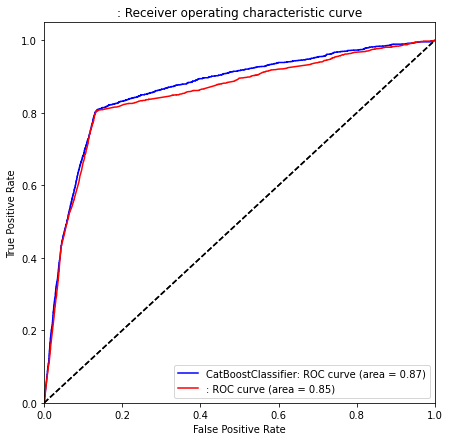

In [51]:
#ROC-кривая
fpr, tpr, _ = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

CatBoostClassifier: AUC_PR = 0.366
LogisticRegression: AUC_PR = 0.350


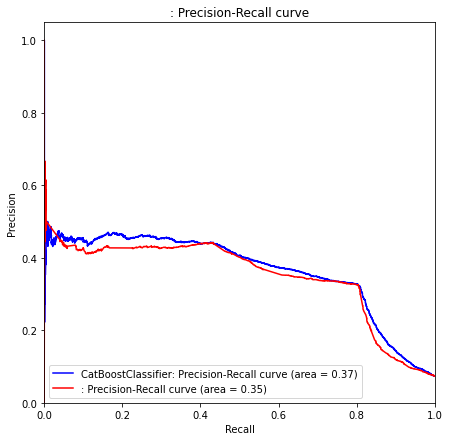

In [53]:
#Precision-Recall-кривая
precision, recall, _ = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

Confusion matrix, without normalization
[[22072  3355]
 [  396  1622]]


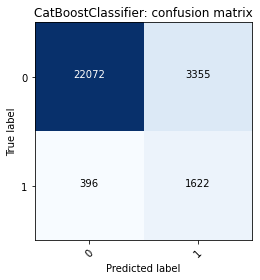

In [54]:
cm = confusion_matrix(y_valid_cat,cat_pred)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="CatBoostClassifier");

In [55]:
print('LogisticRegression')
print(classification_report(y_valid, logreg_pred > 0.5))
print()
print('CatBoostClassifier')
print(classification_report(y_valid_cat,cat_pred))

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25427
         1.0       0.32      0.80      0.46      2018

    accuracy                           0.86     27445
   macro avg       0.65      0.84      0.69     27445
weighted avg       0.93      0.86      0.89     27445


CatBoostClassifier
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25427
         1.0       0.33      0.80      0.46      2018

    accuracy                           0.86     27445
   macro avg       0.65      0.84      0.69     27445
weighted avg       0.93      0.86      0.89     27445



In [56]:
#Финанальная модель
selector = SelectPercentile()
X_cat_fin = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat_fin = pd.DataFrame(X_cat_fin, columns=selected_columns)

X_cat_fin[f_categorical] = X_cat_fin[f_categorical].astype('int').astype('category')

In [57]:
fin_model = CatBoostClassifier(**frozen_params,
                               **best_cat_params)

In [58]:
fin_model.fit(X=X_cat_fin, y=y)

0:	learn: 0.8213920	total: 243ms	remaining: 24s
1:	learn: 0.8213920	total: 488ms	remaining: 23.9s
2:	learn: 0.8213920	total: 677ms	remaining: 21.9s
3:	learn: 0.8213920	total: 876ms	remaining: 21s
4:	learn: 0.8213920	total: 1.08s	remaining: 20.6s
5:	learn: 0.8213920	total: 1.26s	remaining: 19.8s
6:	learn: 0.8213920	total: 1.44s	remaining: 19.1s
7:	learn: 0.8213920	total: 1.66s	remaining: 19.1s
8:	learn: 0.8213920	total: 1.86s	remaining: 18.8s
9:	learn: 0.8213920	total: 2.11s	remaining: 19s
10:	learn: 0.8213920	total: 2.31s	remaining: 18.7s
11:	learn: 0.8213920	total: 2.53s	remaining: 18.6s
12:	learn: 0.8213920	total: 2.74s	remaining: 18.3s
13:	learn: 0.8213920	total: 2.95s	remaining: 18.1s
14:	learn: 0.8213920	total: 3.16s	remaining: 17.9s
15:	learn: 0.8213920	total: 3.37s	remaining: 17.7s
16:	learn: 0.8213920	total: 3.62s	remaining: 17.7s
17:	learn: 0.8213920	total: 3.78s	remaining: 17.2s
18:	learn: 0.8213920	total: 3.99s	remaining: 17s
19:	learn: 0.8213920	total: 4.17s	remaining: 16.7

In [60]:
#Сохраняем
import pickle
with open('final_model.pkl', 'wb') as file:
        pickle.dump(fin_model, file)

In [61]:
#Проверка на тесте
test_df = pd.read_pickle(test_path)

In [62]:
w_sc = StandardScaler().fit_transform(test_df['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

test_df['time_delta'] = w

X_test = test_df.drop(['id','buy_time_vas'], axis=1)

X_test.loc[X_test['252']>1,:] = X_test['252'].value_counts().argmax()

X_cat_test = selector.transform(X_test[f_ok])

X_cat_test = pd.DataFrame(X_cat_test, columns=selected_columns)

X_cat_test[f_categorical] = X_cat_test[f_categorical].astype('int').astype('category')

In [63]:
test_pred_proba = fin_model.predict_proba(X_cat_test)[:,1]

In [64]:
answers_test = test_df[['buy_time_vas', 'id', 'vas_id']].rename(columns={'buy_time_vas': 'buy_time'}).copy()

In [65]:
answers_test['target'] = test_pred_proba

In [66]:
answers_test.head()

,buy_time,id,vas_id,target
0,1.548018e+09,3130519.0,2.0,0.172813
1,1.548018e+09,2000860.0,4.0,0.755558
2,1.546808e+09,1099444.0,2.0,0.247809
3,1.547413e+09,1343255.0,5.0,0.203624
4,1.546808e+09,1277040.0,2.0,0.171167


In [67]:
answers_test.to_csv('answers_test.csv')